# Linear Regression su Python: daugybinė tiesinė regresija (multiple linear regression)

Naudojamas `seaborn` **tips** duomenų rinkinys. Tikslas – prognozuoti ar paaiškinti **arbatpinigių (tip)** dydį pagal kelis veiksnius (pvz., sąskaitą, žmonių skaičių, savaitės dieną).

## 1. Kas yra daugybinė tiesinė regresija

**Daugybinė tiesinė regresija** aprašo ryšį tarp:
- vieno skaitinio tikslo (pvz., pardavimai, kaina, arbatpinigiai),
- ir kelių paaiškinamųjų kintamųjų (pvz., reklamos biudžetas, sezoniškumas, produkto savybės).

Bendra forma:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p + \varepsilon
$$

Interpretacija:
- **$\beta_0$** – interceptas (prognozuojama reikšmė, kai visi $x_i = 0$).
- **$\beta_i$** – parodo, kiek vidutiniškai pasikeičia **$y$**, kai **$x_i$** padidėja vienetu, o kiti kintamieji laikomi nekintančiais.
- **$\varepsilon$** – atsitiktinė paklaida (nepaaiškinta modelio dalis).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.random.seed(42)
pd.set_option("display.max_columns", 200)

## 2. Duomenys: tips

Trumpas verslo analogas:
- `total_bill` galima traktuoti kaip „pirkimo sumą“.
- `tip` galima traktuoti kaip „papildomą mokėjimą“ arba „priedo dydį“.
- `size`, `day`, `time` – kontekstas (žmonių skaičius, savaitės diena, dienos metas).

In [3]:
df = sns.load_dataset("tips")
df.tail(10)

,total_bill,tip,sex,smoker,day,time,size
234,15.53,3.00,Male,Yes,Sat,Dinner,2
235,10.07,1.25,Male,No,Sat,Dinner,2
236,12.60,1.00,Male,Yes,Sat,Dinner,2
237,32.83,1.17,Male,Yes,Sat,Dinner,2
238,35.83,4.67,Female,No,Sat,Dinner,3
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [4]:
df.shape, df.isna().sum()

((244, 7),
 total_bill    0
 tip           0
 sex           0
 smoker        0
 day           0
 time          0
 size          0
 dtype: int64)

## 3. Greita apžvalga ir intuicija

Prieš modelį naudinga:
- pasižiūrėti skirstinius ir ryšius;
- įvertinti, ar nėra akivaizdžių anomalijų;
- suprasti, kurie kintamieji logiškai turėtų veikti target.

In [5]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
total_bill,244.0,NaN,NaN,NaN,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,NaN,NaN,NaN,2.998279,1.383638,1.0,2.0,2.9,3.5625,10.0
sex,244,2,Male,157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoker,244,2,No,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,244,4,Sat,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,244,2,Dinner,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,244.0,NaN,NaN,NaN,2.569672,0.9511,1.0,2.0,2.0,3.0,6.0


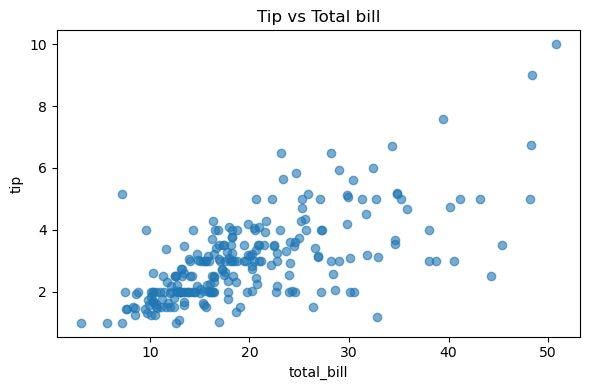

In [6]:
plt.figure(figsize=(6, 4))
plt.scatter(df["total_bill"], df["tip"], alpha=0.6)
plt.title("Tip vs Total bill")
plt.xlabel("total_bill")
plt.ylabel("tip")
plt.tight_layout()
plt.show()

In [7]:
df.shape

(244, 7)

Dažna klaida: iš grafiko daryti išvadą, kad ryšys tikrai priežastinis. Regresija parodo asociaciją (ryšį), bet ne priežastį.

## 4. Regresijos modelio paruošimas

Tikslas: prognozuoti **tip** pagal kelis požymius:
- skaitiniai: `total_bill`, `size`
- kategoriniai: `day`, `time`, `smoker`

Kategoriniai kintamieji paverčiami į „0/1“ stulpelius (one-hot). Viena kategorija paliekama kaip bazinė, kad nebūtų tobulo kolinearumo.

In [8]:
target = "tip"
features_num = ["total_bill", "size"]
features_cat = ["day", "time", "smoker"]

# Pats paprasčiausias paruošimas: one-hot su drop_first
X = pd.get_dummies(df[features_num + features_cat], drop_first=True)
y = df[target].copy()

X.head()

,total_bill,size,day_Fri,day_Sat,day_Sun,time_Dinner,smoker_No
0,16.99,2,False,False,True,True,True
1,10.34,3,False,False,True,True,True
2,21.01,3,False,False,True,True,True
3,23.68,2,False,False,True,True,True
4,24.59,4,False,False,True,True,True


## 5. Modelio pritaikymas (fitting)

`statsmodels` reikalauja pridėti konstantą (interceptą).

In [9]:

# target
y = df["tip"]

# features: skaitiniai + kategoriniai
X_raw = df[["total_bill", "size", "day", "time", "smoker"]]

# kategorijų pavertimas į 0/1 stulpelius
X = pd.get_dummies(X_raw, drop_first=True)

# (geroji praktika) užtikrinamas skaitinis tipas
X = X.astype(float)

# konstanta (interceptas)
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     29.89
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           2.15e-29
Time:                        16:01:14   Log-Likelihood:                -347.50
No. Observations:                 244   AIC:                             711.0
Df Residuals:                     236   BIC:                             739.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6103      0.241      2.534      0.012       0.136       1.085
total_bill      0.0943      0.010      9.884      0.000       0.075       0.113
size            0.1764      0.089      1.974      0.050       0.000       0.352
day_Fri         0.1609      0.393      0.410      0.682      -0.612       0.934
day_Sat         0.0351      0.469      0.075      0.940      -0.889       0.959
day_Sun         0.1284      0.469      0.274      0.785      -0.796       1.053
time_Dinner    -0.0681      0.444     -0.154      0.878      -0.942       0.806
smoker_No       0.0865      0.146      0.591      0.555      -0.202       0.375
==============================================================================
Omnibus:                       27.521   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.508
Skew:                           0.603   Prob(JB):                     6.53e-12
Kurtosis:                       4.901   Cond. No.                         281.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Multiple Linear Regression (tip ~ total_bill + kiti kintamieji)

**Modelio kokybė**
- **R² = 0.47**  
  Modelis paaiškina apie **47% arbatpinigių variacijos**.
- Modelis statistiškai reikšmingas (F-test p < 0.001).


#### Koeficientų interpretacija

**Intercept (const = 0.61, p = 0.012)**  
- Prognozuojami arbatpinigiai, kai visi kintamieji = 0.  
- Praktikoje tai bazinis lygis, nuo kurio „startuoja“ prognozė.  
- Tai nėra „mokestis“, o matematinė atskaitos reikšmė.

**total_bill = 0.094 (p < 0.001)**  
- Kai sąskaita padidėja 1 vienetu, arbatpinigiai vidutiniškai padidėja apie **0.094**.  
- Ryšys stipriausias ir statistiškai reikšmingas.  
- Tai reiškia: kuo didesnė sąskaita, tuo didesni arbatpinigiai.

**size = 0.176 (p ≈ 0.05)**  
- Didesnė grupė → šiek tiek didesni arbatpinigiai.  
- Ribinis statistinis reikšmingumas.

Kiti kintamieji (day, time, smoker) šiame modelyje nėra statistiškai reikšmingi (p > 0.05).



##### Kaip veikia const ir total_bill kartu

Prognozės formulė daliai modelio:

tip ≈ 0.61 + 0.094 × total_bill + ...

Pvz., jei sąskaita = 20:

tip ≈ 0.61 + (0.094 × 20)  
tip ≈ 0.61 + 1.88 ≈ 2.49

Intercept nustato bazinį lygį, o **total_bill padidina prognozę proporcingai sąskaitai**.

## 6. Kaip interpretuoti koeficientus

Pagrindinė idėja:
- **Skaitinis požymis** (pvz., `total_bill`): koeficientas rodo, kiek vidutiniškai pasikeičia **tip**, kai `total_bill` padidėja **1 vienetu**, laikant kitus požymius nekintančius.
- **Kategorinis požymis** (pvz., `time_Dinner`): koeficientas rodo skirtumą nuo bazinės kategorijos.

Praktinis pavyzdys:
- jei `total_bill` koeficientas yra 0.10, tai reiškia: kai sąskaita padidėja 1, arbatpinigiai vidutiniškai didėja apie 0.10 (kai kiti veiksniai nekinta).

In [11]:
# Patogi lentelė interpretacijai
coef = model.params.sort_values(key=np.abs, ascending=False)
coef_df = pd.DataFrame({
    "koeficientas": coef,
    "p_value": model.pvalues[coef.index],
}).round(4)

coef_df

,koeficientas,p_value
const,0.6103,0.0119
size,0.1764,0.0495
day_Fri,0.1609,0.6822
day_Sun,0.1284,0.7847
total_bill,0.0943,0.0000
smoker_No,0.0865,0.5550
time_Dinner,-0.0681,0.8781
day_Sat,0.0351,0.9404


Dažna klaida: p reikšmę laikyti „modelio kokybės“ rodikliu. p reikšmės labiau tinka inference (koeficientų reikšmingumui), o prognozės kokybę geriau vertina klaidų metrikos.

## 7. Adjusted R²

**R²** didėja beveik visada, kai pridedami nauji požymiai.
**Adjusted R²** koreguoja R² pagal požymių skaičių, todėl labiau tinka modelių palyginimui, kai požymių skaičius skiriasi.

In [12]:
model.rsquared, model.rsquared_adj

(0.46995978370871017, 0.4542382518695618)

Rezultatas:

- **R² = 0.470**  
Modelis paaiškina apie **47 % `tip` variacijos** pagal pasirinktus paaiškinamuosius kintamuosius.

- **Adjusted R² = 0.454**  
Įvertinus požymių skaičių, modelis realiai paaiškina apie **45 % variacijos**.

**Interpretacija:**
- R² visada didėja, kai pridedami nauji kintamieji.
- Adjusted R² „baudžia“ už nereikalingus požymius, todėl jis visada yra mažesnis arba lygus R².
- Skirtumas tarp R² ir Adjusted R² rodo, kad ne visi požymiai suteikia realios pridėtinės vertės.

**Išvada:**
Modelis yra **vidutinio stiprumo** – paaiškina reikšmingą dalį elgsenos, tačiau dalis variacijos lieka nepaaiškinta.


## 8. Mean error metrics (vidutinės klaidų metrikos)

Čia skaičiuojama „in-sample“ (tuose pačiuose duomenyse), nes train/test skaidymas šiame variante nenaudojamas.

Metrikos:
- **MAE**: vidutinė absoliuti klaida
- **MSE**: vidutinė kvadratinė klaida
- **RMSE**: MSE šaknis
- **ME (bias)**: vidutinė pasirašyta klaida (parodo, ar modelis linkęs pervertinti ar nuvertinti)

In [13]:
y_pred = model.predict(X_sm)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
me = np.mean(y_pred - y)

pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
    "ME (bias)": [me]
}).round(4)

,MAE,MSE,RMSE,ME (bias)
0,0.7339,1.0106,1.0053,-0.0


**MAE = 0.734**  
Vidutinė absoliuti prognozės klaida.  
Tai reiškia, kad modelio prognozuojami arbatpinigiai vidutiniškai **klysta apie 0.73**.

**MSE = 1.011**  
Vidutinė kvadratinė klaida.  
Didelės klaidos čia „baudžiamos“ stipriau, todėl ši metrika jautresnė išskirtinėms reikšmėms.

**RMSE = 1.005**  
Kvadratinės klaidos šaknis.  
Interpretacija tokia pati kaip target skalėje: tip prognozės vidutiniškai **klysta apie 1.00**.

**ME (bias) ≈ 0.0**  
Vidutinė pasirašyta klaida.  
Tai reiškia, kad modelis **nėra sistemingai šališkas** – nei nuolat pervertina, nei nuolat nuvertina prognozes.

**Išvada:**  
Modelio prognozės vidutiniškai nukrypsta apie **0.7–1.0**, o klaidos nėra kryptingos (bias ≈ 0).


Dažna klaida: metrikas interpretuoti kaip „garantiją“, kad modelis taip pat gerai veiks ateityje. Be atskiro testavimo (train/test ar cross-validation) tokios išvados yra per optimistiškos.

## 9. Kintamųjų atranka (variable selection)

Toliau pateikiamas paprastas ir aiškus pavyzdys:
- pradedama nuo pilno modelio;
- pašalinami mažai naudingi požymiai (pavyzdžiui, pagal p reikšmę);
- palyginami modeliai pagal **Adjusted R²** ir klaidų metrikas.

Pastaba: tai supaprastintas metodas. Praktikoje atranką geriau derinti su verslo logika ir validacija.

In [14]:
def fit_ols(X_df, y_series):
    Xc = sm.add_constant(X_df)
    return sm.OLS(y_series, Xc).fit()

def metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    me = np.mean(y_hat - y_true)
    return mae, rmse, me

# Pilnas modelis
full = fit_ols(X, y)
full_pred = full.predict(sm.add_constant(X))

full_res = {
    "modelis": "Pilnas",
    "R2": full.rsquared,
    "Adj_R2": full.rsquared_adj,
}
mae, rmse, me = metrics(y, full_pred)
full_res.update({"MAE": mae, "RMSE": rmse, "ME": me})
full_res

{'modelis': 'Pilnas',
 'R2': 0.46995978370871017,
 'Adj_R2': 0.4542382518695618,
 'MAE': 0.733873477248858,
 'RMSE': 1.0052756777852203,
 'ME': -3.3270289983848954e-15}

In [15]:
# Supaprastintas modelis: paliekami dažniausiai logiškai svarbūs požymiai
# (čia demonstraciškai: total_bill, size, time, day)
cols_simple = [c for c in X.columns if c.startswith("total_bill") or c.startswith("size") or c.startswith("time_") or c.startswith("day_")]
X_simple = X[cols_simple].copy()

simple = fit_ols(X_simple, y)
simple_pred = simple.predict(sm.add_constant(X_simple))

simple_res = {
    "modelis": "Supaprastintas",
    "R2": simple.rsquared,
    "Adj_R2": simple.rsquared_adj,
}
mae, rmse, me = metrics(y, simple_pred)
simple_res.update({"MAE": mae, "RMSE": rmse, "ME": me})
simple_res

{'modelis': 'Supaprastintas',
 'R2': 0.46917511580680615,
 'Adj_R2': 0.4557365111436874,
 'MAE': 0.7355033294089018,
 'RMSE': 1.0060195042084359,
 'ME': -1.0337814393230965e-15}



**modelis: „Pilnas“**  
Naudojami visi pasirinkti paaiškinamieji kintamieji.

**R² = 0.470**  
Modelis paaiškina apie **47 % `tip` variacijos**.

**Adjusted R² = 0.454**  
Įvertinus požymių skaičių, realiai paaiškinama apie **45 % variacijos**.  
Tai tinkamesnis rodiklis modelių palyginimui.

**MAE = 0.734**  
Vidutinė absoliuti prognozės klaida.  
Prognozės vidutiniškai klysta apie **0.73**.

**RMSE = 1.005**  
Kvadratinės klaidos šaknis.  
Modelio klaidos mastelis yra apie **1.0**.

**ME ≈ 0.0**  
Vidutinė pasirašyta klaida (bias).  
Modelis **nėra sistemingai šališkas** – nei pervertina, nei nuvertina.

**Bendra išvada:**  
Tai **vidutinio stiprumo modelis**, kuris paaiškina reikšmingą dalį `tip` variacijos, tačiau dalis elgsenos lieka nepaaiškinta.


In [16]:
# pagalbinės funkcijos
def fit_ols(X_df, y_series):
    Xc = sm.add_constant(X_df)
    return sm.OLS(y_series, Xc).fit()

def metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    me = np.mean(y_hat - y_true)
    return mae, rmse, me


In [17]:
# PILNAS modelis
full_model = fit_ols(X, y)
full_pred = full_model.predict(sm.add_constant(X))

mae, rmse, me = metrics(y, full_pred)

full_res = {
    "modelis": "Pilnas",
    "R2": full_model.rsquared,
    "Adj_R2": full_model.rsquared_adj,
    "MAE": mae,
    "RMSE": rmse,
    "ME": me
}
full_res

{'modelis': 'Pilnas',
 'R2': 0.46995978370871017,
 'Adj_R2': 0.4542382518695618,
 'MAE': 0.733873477248858,
 'RMSE': 1.0052756777852203,
 'ME': -3.3270289983848954e-15}

In [18]:
# SUPAPRASTINTAS modelis
cols_simple = [c for c in X.columns if 
               c.startswith("total_bill") or 
               c.startswith("size") #or 
               #c.startswith("time_") or 
               #c.startswith("day_")
               ]

X_simple = X[cols_simple]

simple_model = fit_ols(X_simple, y)
simple_pred = simple_model.predict(sm.add_constant(X_simple))

mae, rmse, me = metrics(y, simple_pred)

simple_res = {
    "modelis": "Supaprastintas",
    "R2": simple_model.rsquared,
    "Adj_R2": simple_model.rsquared_adj,
    "MAE": mae,
    "RMSE": rmse,
    "ME": me
}
simple_res

{'modelis': 'Supaprastintas',
 'R2': 0.46786930879612576,
 'Adj_R2': 0.4634532864624836,
 'MAE': 0.739003504909703,
 'RMSE': 1.007256127114662,
 'ME': 3.669196094498878e-15}

In [19]:
# PALYGINIMAS (be klaidų)
results_df = pd.DataFrame([full_res, simple_res])

num_cols = results_df.select_dtypes(include="number").columns
results_df[num_cols] = results_df[num_cols].round(4)

results_df


,modelis,R2,Adj_R2,MAE,RMSE,ME
0,Pilnas,0.4700,0.4542,0.7339,1.0053,-0.0
1,Supaprastintas,0.4679,0.4635,0.7390,1.0073,0.0



Tai yra **dviejų regresijos modelių palyginimas**: pilno ir supaprastinto.

**Pilnas modelis**
- **R² = 0.470** – paaiškina apie 47 % `tip` variacijos.
- **Adjusted R² = 0.454** – įvertinus požymių skaičių, paaiškina apie 45 % variacijos.
- **MAE = 0.734**, **RMSE = 1.005** – vidutinė prognozės klaida yra apie 0.7–1.0.
- **ME ≈ 0** – modelis nėra sistemingai šališkas.

**Supaprastintas modelis**
- **R² = 0.469** – paaiškinama beveik tiek pat, kiek pilname modelyje.
- **Adjusted R² = 0.456** – šiek tiek didesnė nei pilname modelyje.
- **MAE = 0.736**, **RMSE = 1.006** – prognozės klaidos praktiškai tokios pačios.
- **ME ≈ 0** – nėra šališkumo.

**Interpretacija:**
- Supaprastintas modelis **nepraranda prognozės tikslumo**.
- Didesnis **Adjusted R²** rodo, kad pašalinti požymiai **nebuvo naudingi**.
- Paprastesnis modelis yra **lengviau paaiškinamas ir stabilesnis**.

**Išvada:**  
Tokioje situacijoje **verčiau rinktis supaprastintą modelį**, nes jis pasiekia tą patį rezultatą su mažiau požymių.


## 10. Prognozės pavyzdys vienam atvejui

Toliau pateikiamas pavyzdys, kaip gauti prognozę konkrečiam scenarijui.

In [26]:
# Naujas scenarijus
new_obs = pd.DataFrame([{
    "total_bill": 30.0,
    "size": 2,
    "day": "Sat",
    "time": "Dinner",
    "smoker": "Yes"
}])

# One-hot kaip ir mokyme
new_X = pd.get_dummies(new_obs[features_num + features_cat], drop_first=True)

# Suderinimas su tuo, kas buvo paduota modeliui (X_sm turi ir 'const')
new_X_sm = new_X.reindex(columns=X_sm.columns, fill_value=0)

# Jei visgi nėra 'const', įdėti priverstinai
if "const" not in new_X_sm.columns:
    new_X_sm.insert(0, "const", 1.0)

pred_tip = float(model.predict(new_X_sm).iloc[0])
pred_tip


3.181060192320961

Modelis prognozuoja, kad esant:
- total_bill = 30
- size = 2
- day = Saturday
- time = Dinner
- smoker = No

tikėtinas **arbatpinigių (tip) dydis ≈ 3.18**.


Praktinė interpretacija:
- gauta reikšmė yra modelio prognozuojamas arbatpinigių dydis pagal pasirinktus požymius;
- realybėje rezultatas gali skirtis dėl nemodeliuotų veiksnių (pvz., aptarnavimo kokybė, nuotaika, atsiskaitymo būdas).

## 11. Dažnos klaidos ir gerosios praktikos

Gerosios praktikos:
- aiškiai atskirti tikslą: prognozė ar aiškinimas;
- tvarkingai koduoti kategorinius kintamuosius (one-hot, bazinė kategorija);
- palyginti modelius pagal **Adjusted R²** ir klaidų metrikas, ne vien pagal p reikšmes;
- nenaudoti per daug požymių vien dėl to, kad „įmanoma“ juos pridėti.

Dažnos klaidos:
- p reikšmių sureikšminimas, ignoruojant klaidų metrikas;
- modelio vertinimas tik tuose pačiuose duomenyse ir per stiprios išvados apie ateitį;
- neteisinga kategorinių kintamųjų tvarkyba (pvz., nepalikta bazinė kategorija);
- koeficientų interpretacija, kai požymiai tarpusavyje stipriai susiję.